In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from math import nan, inf
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import os
import re
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import pickle

In [2]:
import sys
sys.path.insert(1, '/Users/yulia/Documents/Repositories/trading_model/utils')
from data_utils import grid_search_params

In [63]:
with open('demand_models_spec.pkl', 'rb') as file:
     models_dict = pickle.load(file)

In [4]:
p_value = 0.05
r_sq = 0.6
brand = 'Fendi'
#state = 'study'
state = 'train'
if brand not in models_dict:
    models_dict[brand] = {}

In [5]:
df = pd.read_pickle('../data/%s_refined.pkl' %brand)

with open('../data/search_trends.pkl', 'rb') as f:
    trends_dict = pickle.load(f)

In [6]:
supply_stats = pd.pivot_table(df[df.apply(lambda x: x['sc_date'] == x['sc_date_first_date'], axis = 1)],
                      values = 'bags_price_refined', index = 'sc_date' , 
                              aggfunc = ['count', np.mean]).reset_index()[1:]

supply_dict = dict(zip(supply_stats['sc_date'], supply_stats['count']['bags_price_refined']))
price_dict = dict(zip(supply_stats['sc_date'], supply_stats['mean']['bags_price_refined']))

In [7]:
df = df[df['ever_sold'] == 1]

In [8]:
#add new trends files

cols = [col for col in df.columns if 'search' not in col]
df = df[cols]

In [9]:
list(trends_dict[brand].keys())

['search_tradesy_fendi', 'search_fendi', 'search_fendi_kan_i']

In [10]:
for keyword in list(trends_dict[brand].keys()):
    df[keyword] = df['sc_date'].map(trends_dict[brand][keyword])

In [11]:
X = pd.DataFrame({'sc_date': df['sc_date'].drop_duplicates()}).sort_values('sc_date').reset_index(drop=True)

In [12]:
max_df_date = max(X['sc_date'])
min_df_date = min(X['sc_date'])

In [13]:
stats = pd.pivot_table(df[df.apply(lambda x: x['sc_date'] == x['sc_date_last_date'] and 
                                   x['status'] == 'Complete', axis = 1)],
                      values = 'id', index = 'sc_date' , aggfunc = 'count').reset_index()[:-1]

In [14]:
stats

,sc_date,id
0,2019-02-20,1
1,2019-02-24,1
2,2019-02-27,1
3,2019-03-01,1
4,2019-03-05,1
5,2019-03-11,2
6,2019-03-16,1
7,2019-03-17,1
8,2019-03-23,1
9,2019-04-07,1


In [15]:
X = pd.merge(X, stats, how='left').fillna(0)

In [16]:
def demand_trend(cur_date, last_n):
    if cur_date - datetime.timedelta(days = last_n * 2) <= max_df_date:
        demand_current = sum(X[X['sc_date'].map(lambda x: 
            cur_date - datetime.timedelta(days = last_n) <= x < cur_date)]['id'])
        demand_basis = sum(X[X['sc_date'].map(lambda x: 
            cur_date - datetime.timedelta(days = last_n * 2) <= x < 
            cur_date - datetime.timedelta(days = last_n))]['id'])
        return demand_current, demand_current / demand_basis if demand_basis > 0 else 0
    else:
        return nan, nan

In [17]:
X['demand_7'], X['demand_7_trend'] = zip(*X['sc_date'].map(lambda x: demand_trend(x, 7)))

In [18]:
X

,sc_date,id,demand_7,demand_7_trend
0,2019-02-11,0.0,0.0,0.0
1,2019-02-12,0.0,0.0,0.0
2,2019-02-13,0.0,0.0,0.0
3,2019-02-14,0.0,0.0,0.0
4,2019-02-15,0.0,0.0,0.0
...,...,...,...,...
83,2019-05-07,0.0,2.0,1.0
84,2019-05-08,0.0,2.0,1.0
85,2019-05-09,0.0,1.0,0.5
86,2019-05-10,0.0,1.0,0.5


In [19]:
#X['demand_14'], X['demand_14_trend'] = zip(*X['sc_date'].map(lambda x: demand_trend(x, 14)))

In [20]:
def search_trend(date, keyword, lag=7):
    date = date - datetime.timedelta(days=lag)
    return trends_dict[brand][keyword][date]

In [21]:
for column in list(trends_dict[brand].keys()):
    X[column+'_7'] = X['sc_date'].map(lambda x: search_trend(x, column, 7))
    X[column+'_0'] = X['sc_date'].map(lambda x: search_trend(x, column, 0))
    X[column+'_14'] = X['sc_date'].map(lambda x: search_trend(x, column, 14))

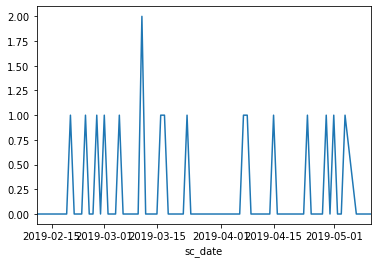

In [22]:
series1 = pd.Series(list(X['id']), index=X['sc_date'])
series1.plot()
plt.show()

In [23]:
def supply_trend(cur_date, last_n):
    min_date = cur_date - datetime.timedelta(days = last_n)
    if min_date >= min_df_date:
        supply_current = sum([supply_dict[date] for date in supply_dict.keys() if
                             min_date <= date < cur_date])
        prices_current = sum([price_dict[date] for date in price_dict.keys() if
                             min_date <= date < cur_date])
        return supply_current, prices_current / supply_current if supply_current > 0 else 0
    else:
        return nan, nan

In [24]:
X['supply_7'], X['supply_7_prices'] = zip(*X['sc_date'].map(lambda x: supply_trend(x, 7)))

In [25]:
def demand(date, n_days=30):
    max_date = date + datetime.timedelta(days=n_days)
    if max_date <= max_df_date:
        future_demand = sum(X[X['sc_date'].map(lambda x: 
            date < x <= max_date)]['id'])
        return future_demand
    else:
        return nan

In [26]:
X['demand'] = X['sc_date'].map(lambda x: demand(x, 30))

In [27]:
series = pd.Series(list(X['demand']), index=X['sc_date'])
'''series_1 = pd.Series(list(X['search_classic_flap_0']), index=X['sc_date'])
series_2 = pd.Series(list(X['search_tradesy_chanel_0']), index=X['sc_date'])
series_3 = pd.Series(list(X['search_chanel_0']), index=X['sc_date'])'''

"series_1 = pd.Series(list(X['search_classic_flap_0']), index=X['sc_date'])\nseries_2 = pd.Series(list(X['search_tradesy_chanel_0']), index=X['sc_date'])\nseries_3 = pd.Series(list(X['search_chanel_0']), index=X['sc_date'])"

In [28]:
series.dropna().index[-20]

datetime.date(2019, 3, 23)

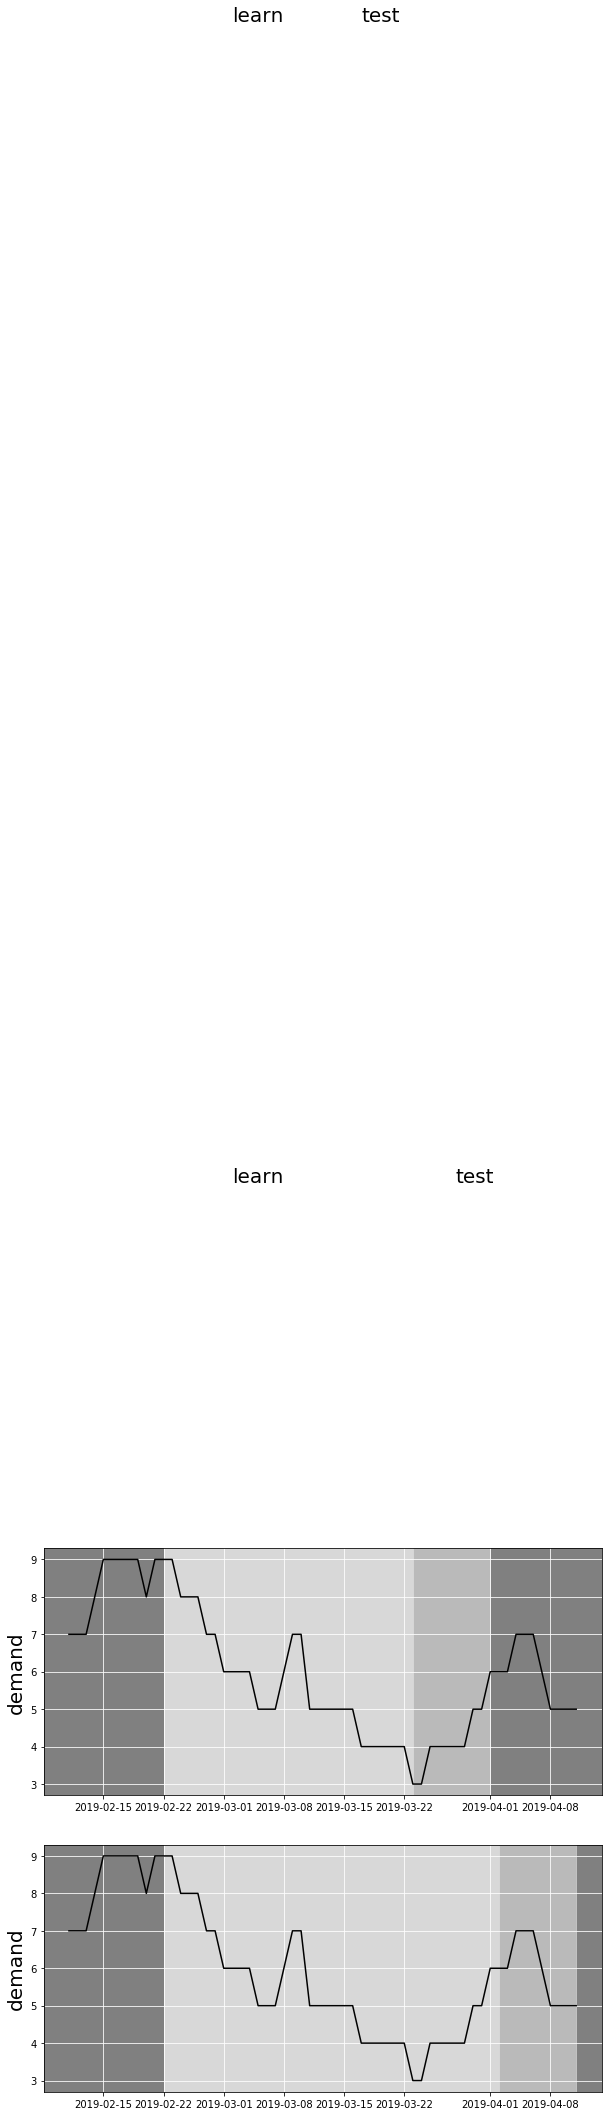

In [29]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1, sharey=ax1)

ax1.plot(series.dropna(), color='black')
ax1.axvspan(datetime.date(2019,2,22), series.dropna().index[-20], alpha=0.7, color='white')
ax1.axvspan(series.dropna().index[-20], series.dropna().index[-11], alpha=0.7, color='lightgrey')
ax1.patch.set_facecolor('grey')
ax1.set_ylabel("demand", fontsize=20)
ax1.grid(True,color='white')

ax2.plot(series.dropna(), color='black')
ax2.axvspan(datetime.date(2019,2,22), series.dropna().index[-10], alpha=0.7, color='white')
ax2.axvspan(series.dropna().index[-10], series.dropna().index[-1], alpha=0.7, color='lightgrey')
ax2.patch.set_facecolor('grey')
ax2.set_ylabel("demand", fontsize=20)

plt.text(datetime.date(2019,3,2), 58, 'learn', fontsize=20)
plt.text(datetime.date(2019,3,17), 58, 'test', fontsize=20)
plt.text(datetime.date(2019,3,2), 27, 'learn', fontsize=20)
plt.text(datetime.date(2019,3,28), 27, 'test', fontsize=20)
plt.grid(True,color='white')
plt.show()

In [30]:
X.columns

Index(['sc_date', 'id', 'demand_7', 'demand_7_trend', 'search_tradesy_fendi_7',
       'search_tradesy_fendi_0', 'search_tradesy_fendi_14', 'search_fendi_7',
       'search_fendi_0', 'search_fendi_14', 'search_fendi_kan_i_7',
       'search_fendi_kan_i_0', 'search_fendi_kan_i_14', 'supply_7',
       'supply_7_prices', 'demand'],
      dtype='object')

In [31]:
X['const'] = 1
cols = list(set(X.columns) - {'sc_date', 'id', 'const'})
lr_cols = list(set(X.columns) - {'sc_date', 'id', 'demand', 'const'})
X = X.dropna()

In [32]:
len(cols)

14

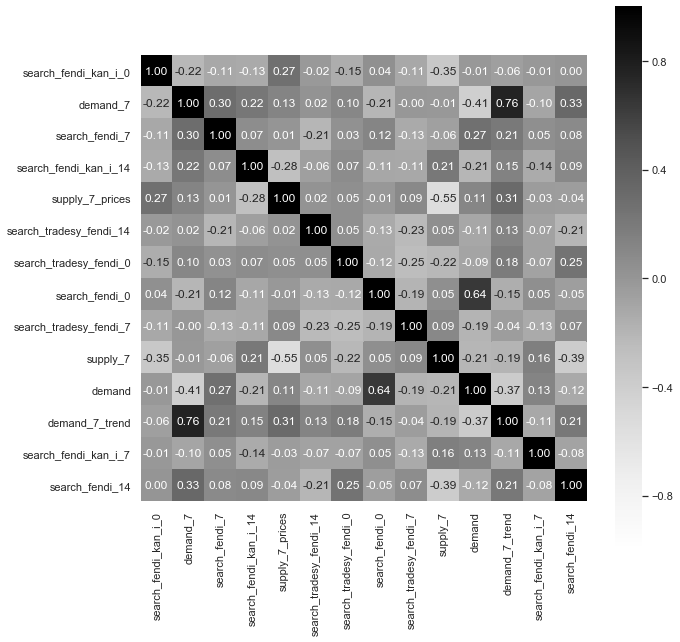

In [33]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(X[cols].dropna().corr(), annot = True, square=True, fmt='.2f', vmin=-1, vmax=1, center= 0, cmap= 'Greys')

In [34]:
xgb_params = {
    "subsample": [0.1, 0.2, 0.3, 0.4] ,
    "max_depth": [4, 6, 8],
    "min_child_weight": [1, 2, 3],
    "colsample_bytree": [0.6, 0.8, 1]
}

pls_params = {
    'n_components': list(range(1, len(cols)))
}

In [35]:
def weighted_rmse(stats):
    return stats[0]/3+stats[1]*2/3

# XGBRegressor

In [36]:
#X, y = X.dropna()[cols], X.dropna()['demand']

if state == 'study':
    best_xgb_params = None
    best_xgb_metric = inf
    for params in grid_search_params(xgb_params):
        print(params)
        y_pred_xgb = list()
        rmse_xgb = list()
        for learn_size in [X.shape[0]-20, X.shape[0]-10]:
            df_train, df_test = X[cols][:learn_size], X[cols][learn_size:learn_size+10]
            #df_train, df_test = train_test_split(xgb_df[cols], test_size=0.3, random_state=12)

            X_train, X_test = df_train[list(set(cols) - {'demand'})],df_test[list(set(cols) - {'demand'})]
            y_train, y_test = df_train['demand'],df_test['demand']

            xgb = XGBRegressor(**params)
            xgb.fit(X_train,y_train)
            y_pred_xgb.append(list(xgb.predict(X_test)))
            #y_pred = [round(item, 0) for item in y_pred]
            rmse_xgb.append(np.sqrt(mean_squared_error(y_pred_xgb[-1],y_test)))
        if weighted_rmse(rmse_xgb) < best_xgb_metric:
            best_xgb_metric = weighted_rmse(rmse_xgb)
            best_xgb_params = params
            y_pred_xgb_graph = y_pred_xgb
    models_dict[brand]['xgbr']['params'] = best_xgb_params
    print(best_xgb_params)

In [37]:
if state == 'train':
    xgb_df = X[cols].dropna()
    df_train = xgb_df[cols]
    #df_train, df_test = train_test_split(xgb_df[cols], test_size=0.3, random_state=12)
    
    xgbr_cols = list(set(cols) - {'demand'})
    X_train = df_train[xgbr_cols]
    y_train = df_train['demand']
    
    params = models_dict[brand]['xgbr']['params']
    xgbr = XGBRegressor(**params)
    xgbr.fit(X_train,y_train)
    models_dict[brand]['xgbr']['spec'], models_dict[brand]['xgbr']['features'] = xgbr, xgbr_cols

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Method .as_matrix will be removed in a future version. Use .values instead.


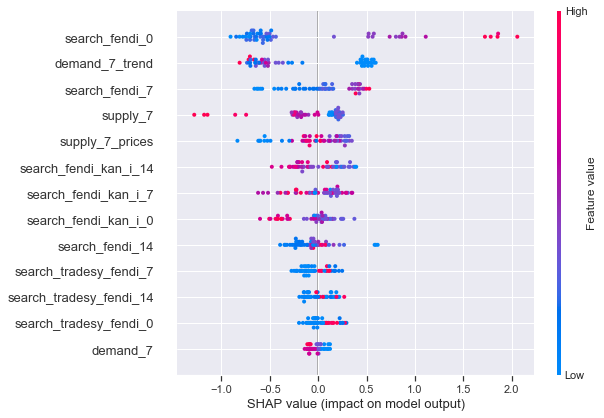

In [38]:
if state == 'train':
    import shap
    shap.initjs()
    explainer = shap.TreeExplainer(xgbr)
    shap_values = explainer.shap_values(X_train.as_matrix())
    shap.summary_plot(shap_values, X_train)

# Linear Regression

In [39]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [40]:
from itertools import combinations
if state == 'study':
    best_mr_params = None
    best_mr_metric = inf
    for i in range(1,len(lr_cols)):
        print(i)
        for features in combinations(lr_cols, i):
            f_list = list(features)
            for f in [f_list, f_list+['const']]:
                rmse_mr = list()
                y_pred_mr = list()
                for learn_size in [X.shape[0]-20, X.shape[0]-10]:
                    df_train= X[:learn_size]        
                    X_train, y_train = df_train[f+['demand']].dropna()[f], df_train[f+['demand']].dropna()['demand']
                    est = sm.OLS(y_train, X_train)
                    est2 = est.fit()
                    if len([pvalue for pvalue in est2.pvalues if pvalue < p_value]) == i and est2.rsquared_adj > r_sq and \
                    est2.f_pvalue < p_value:
                        df_test = X[learn_size:learn_size+10]
                        X_test, y_test = df_test[f], df_test['demand']
                        y_pred_mr.append(list(est2.predict(X_test)))
                        rmse_mr.append(np.sqrt(mean_squared_error(y_pred_mr[-1],y_test)))
                
                if len(rmse_mr) == 2 and weighted_rmse(rmse_mr) < best_mr_metric:
                    best_mr_metric = weighted_rmse(rmse_mr)
                    best_mr_params = f
                    y_pred_mr_graph = y_pred_mr
    print(best_mr_params)
    print(best_mr_metric)
    models_dict[brand]['mlr']['params'] = best_mr_params
                                          

In [41]:
if state == 'train':
    f = models_dict[brand]['mlr']['params']
    df_train = X        
    X_train, y_train = df_train[f+['demand']].dropna()[f], df_train[f+['demand']].dropna()['demand']
    est = sm.OLS(y_train, X_train)
    mr = est.fit()
    models_dict[brand]['mlr']['spec'], models_dict[brand]['mlr']['features'] = mr, f
    print(mr.summary())

                                 OLS Regression Results                                
Dep. Variable:                 demand   R-squared (uncentered):                   0.874
Model:                            OLS   Adj. R-squared (uncentered):              0.869
Method:                 Least Squares   F-statistic:                              176.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):                    1.17e-23
Time:                        00:27:33   Log-Likelihood:                         -115.14
No. Observations:                  53   AIC:                                      234.3
Df Residuals:                      51   BIC:                                      238.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [42]:
models_dict[brand]['mlr']['params']

['search_fendi_kan_i_7', 'supply_7_prices']

# Partial least squares

In [43]:
from sklearn.cross_decomposition import PLSRegression

In [44]:
if state == 'study':
    best_pls_params = None
    pls_features = None
    best_pls_metric = inf
    for i in range(1,len(lr_cols)):
        print(i)
        for features in combinations(lr_cols, i):
            cols = list(features) + ['demand']
            for params in grid_search_params(pls_params):
                #print(params)
                y_pred_pls = list()
                rmse_pls = list()
                for learn_size in [X.shape[0]-20, X.shape[0]-10]:
                    df_train, df_test = X[cols][:learn_size], X[cols][learn_size:learn_size+10]

                    X_train, X_test = df_train[list(set(cols) - {'demand'})],df_test[list(set(cols) - {'demand'})]
                    y_train, y_test = df_train['demand'],df_test['demand']

                    pls = PLSRegression(**params)
                    try:
                        pls.fit(X_train,y_train)
                        y_pred_pls.append([i[0] for i in pls.predict(X_test)])
                        rmse_pls.append(np.sqrt(mean_squared_error(y_pred_pls[-1],y_test)))
                    except:
                        rmse_pls = [inf, inf]
                if weighted_rmse(rmse_pls) < best_pls_metric:
                    best_pls_metric = weighted_rmse(rmse_pls)
                    best_pls_params = params
                    pls_features = cols[:-1]
                    y_pred_pls_graph = y_pred_pls
    models_dict[brand]['pls']['params'] = best_pls_params
    models_dict[brand]['pls']['features'] = pls_features
    print(best_pls_params)
    print(best_pls_metric)
    print(pls_features)

In [45]:
if state == 'train':
    pls_df = X[cols].dropna()
    df_train = pls_df[cols]
    #df_train, df_test = train_test_split(xgb_df[cols], test_size=0.3, random_state=12)
    
    pls_cols = models_dict[brand]['pls']['features']
    X_train = df_train[pls_cols]
    y_train = df_train['demand']
    
    params = models_dict[brand]['pls']['params']
    pls = PLSRegression(**params)
    pls = pls.fit(X_train,y_train)
    models_dict[brand]['pls']['spec'] = pls

In [46]:
def _calculate_vips(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips

In [47]:
if state == 'train':
    vips = _calculate_vips(pls)
    vips_df = pd.DataFrame({'Feature': pls_cols, 'Variable influence on projection': vips})
    print(vips_df)

                Feature  Variable influence on projection
0       search_fendi_14                          0.440594
1        search_fendi_7                          0.827909
2  search_fendi_kan_i_0                          0.333023
3        search_fendi_0                          1.960454
4  search_fendi_kan_i_7                          0.442238
5        demand_7_trend                          1.124653
6              supply_7                          0.840083


# ARIMAX model

In [48]:
# import pyflux as pf

In [49]:
# f = [feature for feature in f if 'demand' not in feature]

In [50]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.stattools import acf, pacf

In [51]:
# if state == 'study':
#     X['demand'].diff(periods=1).plot(color='red')
#     X['demand'].diff(periods=1).diff(periods=1).plot(color='blue')
#     plot_acf(X['demand'][:-20], lags=10)
#     plot_pacf(X['demand'][:-20], lags=10)
#     plot_acf(X['demand'][:-10], lags=10)
#     plot_pacf(X['demand'][:-10], lags=10)
#     plt.show()
# if state == 'train':
#     X['demand'].diff(periods=1).plot(color='red')
#     X['demand'].diff(periods=1).diff(periods=1).plot(color='blue')
#     plot_acf(X['demand'], lags=10)
#     plot_pacf(X['demand'], lags=10)
#     plt.show()

In [52]:
# parameters_dict = {
#     'Chanel': {'study': [2,1,1,3,1,1],
#               'train': [4,1,2]
#               },
#     'Louis Vuitton': {'study': [2,1,2,2,1,2],
#                      'train': [2,1,2]
#                      },
#     'Gucci': {'study': [2,8,2,3,1,2],
#              'train': [4,1,2]
#              },
#     'Saint Laurent': {'study': [2,1,2,3,9,2],
#                      'train': [4,6,2]
#                      },
#     'Fendi': {'study': [2,1,2,3,1,2],
#              'train': [3,1,2]
#              }
# }

In [53]:
# if 'const' in f:
#     f.remove('const')

In [54]:
# def choose_best_spec(max_ar, max_ma, integ, data, f):
#     best_spec = [0,0,0]
#     best_bic = inf
#     for ar in range(max_ar + 1):
#         for ma in range(max_ma + 1):
#             try:
#                 arimax = ARIMA(data['demand'], order=(ar, integ, ma), exog = data[f])
#                 x = arimax.fit(disp=0)
#                 local_bic = x.bic
#                 print(local_bic)
#                 if local_bic < best_bic:
#                     best_bic = local_bic
#                     best_spec = [ar,ma,integ]
#             except Exception as e:
#                 if 'The computed initial MA coefficients are not invertible' in str(e):
#                     continue
#                 else:
#                     print(e)
#     print('Best bic: %d. Best params: ar=%s, ma=%s. Integ=%s' %(best_bic, best_spec[0], best_spec[1],best_spec[2]))
#     return best_spec

In [55]:
# if state == 'study':
#     y_pred_arimax = list()
#     rmse_arimax = list()
#     iteration = 0
#     max_ar1 = parameters_dict[brand][state][0]
#     max_ma1 = parameters_dict[brand][state][1]
#     integ1 = parameters_dict[brand][state][2]
#     max_ar2 = parameters_dict[brand][state][3]
#     max_ma2 = parameters_dict[brand][state][4]
#     integ2 = parameters_dict[brand][state][5]
#     for learn_size in [X.shape[0]-20, X.shape[0]-10]:
#         if iteration == 0:
#             ar, ma, integ = choose_best_spec(max_ar1, max_ma1, integ1, X[:learn_size], f)
#         elif iteration == 1:
#             ar, ma, integ = choose_best_spec(max_ar2, max_ma2, integ2, X[:learn_size], f)
#         print(ar, ma, integ)
#         arimax = ARIMA(X[:learn_size]['demand'], order=(ar, integ, ma), exog = X[:learn_size][f])
#         x = arimax.fit(disp=0)
#         print(x.summary())
        
#         arimax_pred = x.forecast(steps=10, exog=X[learn_size:learn_size+10][f])[0]
#         #y_diff_pred = arimax.predict(h=10, oos_data=X[learn_size:learn_size+10])
#         y_pred_arimax.append(list(arimax_pred))
#         #y_pred = [round(value, 0) for value in y_pred]
#         rmse3 = np.sqrt(mean_squared_error(y_pred_arimax[-1],y_test))
#         rmse_arimax.append(rmse3)
#         iteration += 1
#     print(rmse_arimax)

In [56]:
# if state == 'train':
#     max_ar3 = parameters_dict[brand][state][0]
#     max_ma3 = parameters_dict[brand][state][1]
#     integ3 = parameters_dict[brand][state][2]
#     ar, ma, integ = choose_best_spec(max_ar3, max_ma3, integ3, X, f)
#     arimax = ARIMA(X['demand'], order=(ar, integ, ma), exog = X[f])
#     x = arimax.fit(disp=0)
#     models_dict[brand]['arimax'] = {'optimal': [ar, integ, ma], 'maximal': (max_ar3, integ3, max_ma3),
#                                     'features': f}
#     x.summary()

In [57]:
# ar, ma, integ

In [58]:
if state == 'study':
    y_pred_ensemble = list()
    for it in range(2):
        y_pred_ensemble.append([(y_pred_pls_graph[it][i] + y_pred_xgb_graph[it][i] + y_pred_mr_graph[it][i]) / 3
                                for i in range(len(y_pred_pls_graph[it]))])
        rmse_ensemble = list()
    for it in range(2):
        mse4 = np.sqrt(mean_squared_error(y_pred_ensemble[it],y_test))
        rmse_ensemble.append(mse4)
    rmse_ensemble = list()
    for it in range(2):
        mse4 = np.sqrt(mean_squared_error(y_pred_ensemble[it],y_test))
        rmse_ensemble.append(mse4)
    rmse_dict = {'xgbr': best_xgb_metric, 'mlr': best_mr_metric,
                'pls': best_pls_metric, 'ensemble': weighted_rmse(rmse_ensemble)}
    print('XGBR: %s' %best_xgb_metric)
    print('MR: %s' %best_mr_metric)
    print('PLS: %s' %best_pls_metric)
    print('Ensemble: %s' %weighted_rmse(rmse_ensemble))
    best_model = min(rmse_dict, key=rmse_dict.get)
    models_dict[brand]['best_model'] = {'model': best_model, 'rmse': rmse_dict[best_model]}

In [59]:
if state == 'study':
    fig = plt.figure(figsize=(15, 10))

    pl_1 = fig.add_subplot(2, 2, 1)
    pl_1.patch.set_facecolor('lightgrey')
    pl_1.plot(pd.Series(data=y_pred_xgb_graph[0], index = X['sc_date'][-20:-10]), marker='o', color='grey')
    pl_1.plot(pd.Series(data=y_pred_xgb_graph[1], index = X['sc_date'][-10:]), marker='x', color='grey')
    pl_1.plot(series.dropna(), color='black')
    pl_1.axvspan(series.dropna().index[-20], series.dropna().index[-11], alpha=0.7, color='white')
    pl_1.axvspan(series.dropna().index[-10], series.dropna().index[-1], alpha=0.7, color='white')
    plt.title('Extreme Gradient Boosting Regression', fontsize=20)
    pl_1.xaxis.grid()
    pl_1.set_ylabel("Кількість", fontsize=20)
    pl_1.tick_params(labelsize=12)
    pl_1.legend(('Прогноз І ітерації', 'Прогноз ІІ ітерації', 'Агрегований попит'), loc='upper left',
                fontsize=14, facecolor='white')


    pl_2 = fig.add_subplot(2, 2, 2, sharex=pl_1, sharey=pl_1)
    pl_2.patch.set_facecolor('lightgrey')
    pl_2.plot(pd.Series(data=y_pred_mr_graph[0], index = X['sc_date'][-20:-10]), marker='o', color='grey')
    pl_2.plot(pd.Series(data=y_pred_mr_graph[1], index = X['sc_date'][-10:]), marker='x', color='grey')
    pl_2.xaxis.grid()
    pl_2.axvspan(series.dropna().index[-20], series.dropna().index[-11], alpha=0.7, color='white')
    pl_2.axvspan(series.dropna().index[-10], series.dropna().index[-1], alpha=0.7, color='white')
    pl_2.plot(series.dropna(), color='black')
    pl_2.set_ylabel("Кількість", fontsize=20)
    plt.title('Multiple Linear Regression', fontsize=20)
    pl_2.tick_params(labelsize=12)
    pl_2.legend(('Прогноз І ітерації', 'Прогноз ІІ ітерації', 'Агрегований попит'), loc='upper left',
                fontsize=14, facecolor='white')


    pl_3 = fig.add_subplot(2, 2, 3, sharex=pl_1, sharey=pl_1)
    pl_3.patch.set_facecolor('lightgrey')
    pl_3.plot(pd.Series(data=y_pred_pls_graph[0], index = X['sc_date'][-20:-10]), marker='o', color='grey')
    pl_3.plot(pd.Series(data=y_pred_pls_graph[1], index = X['sc_date'][-10:]), marker='x', color='grey')
    pl_3.axvspan(series.dropna().index[-20], series.dropna().index[-11], alpha=0.7, color='white')
    pl_3.axvspan(series.dropna().index[-10], series.dropna().index[-1], alpha=0.7, color='white')
    pl_3.plot(series.dropna(), color='black')
    pl_3.xaxis.grid()
    pl_3.set_ylabel("Кількість", fontsize=20)
    plt.title('Partial Least Squares Regression', fontsize=20)
    pl_3.tick_params(labelsize=12)
    pl_3.legend(('Прогноз І ітерації', 'Прогноз ІІ ітерації', 'Агрегований попит'), loc='upper left',
                fontsize=14, facecolor='white')


    pl_4 = fig.add_subplot(2, 2, 4, sharex=pl_1, sharey=pl_1)
    pl_4.patch.set_facecolor('lightgrey')
    pl_4.plot(pd.Series(data=y_pred_ensemble[0], index = X['sc_date'][-20:-10]), marker='o', color='grey')
    pl_4.plot(pd.Series(data=y_pred_ensemble[1], index = X['sc_date'][-10:]), marker='x', color='grey')
    pl_4.plot(series.dropna(), color='black')
    pl_4.axvspan(series.dropna().index[-20], series.dropna().index[-11], alpha=0.7, color='white')
    pl_4.axvspan(series.dropna().index[-10], series.dropna().index[-1], alpha=0.7, color='white')
    pl_4.xaxis.grid()
    pl_4.set_ylabel("Кількість", fontsize=20)
    plt.title('Ensemble', fontsize=20)
    pl_4.tick_params(labelsize=12)
    pl_4.legend(('Прогноз І ітерації', 'Прогноз ІІ ітерації', 'Агрегований попит'), loc='upper left',
                fontsize=14, facecolor='white')
    
    #fig.autofmt_xdate()
    
    plt.setp(pl_1.get_xticklabels(), rotation=45, ha="right")
    plt.setp(pl_2.get_xticklabels(), rotation=45, ha="right")
    plt.setp(pl_3.get_xticklabels(), rotation=45, ha="right")
    plt.setp(pl_4.get_xticklabels(), rotation=45, ha="right")
    
    fig.tight_layout()
    plt.show()

In [82]:
with open('demand_models_spec.pkl', 'wb') as file:
    pickle.dump(models_dict, file)

In [61]:
print('Success!')

Success!


In [62]:
models_dict

{'Chanel': {'xgbr': {'spec': XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints=None,
                learning_rate=0.300000012, max_delta_step=0, max_depth=4,
                min_child_weight=2, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=0, num_parallel_tree=1,
                objective='reg:squarederror', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, subsample=0.2, tree_method=None,
                validate_parameters=False, verbosity=None),
   'features': ['search_tradesy_chanel_7',
    'search_chanel_7',
    'supply_7_prices',
    'search_chanel_0',
    'demand_7',
    'search_classic_flap_7',
    'search_tradesy_chanel_14',
    'search_chanel_14',
    'search_tradesy_chanel_0',
    'search_classic_flap_14',
    'search_classic_flap_0',
    'supply_7',
    'dema